# Denoising

In this simple notebook, we look at a denoising problem and how the linearized bregman iterations provide a simple and efficient solution.

# Packages setup

In [1]:
# ] registry add https://github.com/slimgroup/SLIMregistryJL.git
# ] add LinearAlgebra, JOLI, TestImages, ImageView

In [2]:
using SlimOptim, LinearAlgebra, JOLI, TestImages, PyPlot

# Use a standard reference imaege

In [3]:
n = 256
n1, n2 = 2*256, 256
img = Float32.(testimage("lena_gray_16bit.png"));

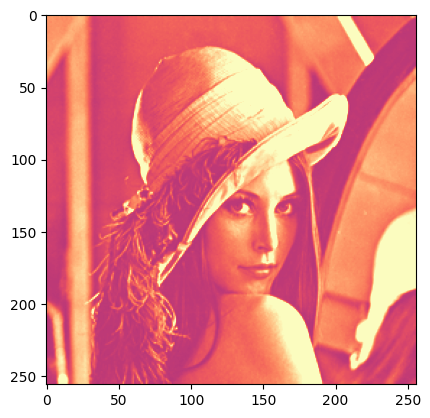

In [4]:
imshow(img, cmap="magma", vmin=-.5, vmax=.5);

# Measurment operator

In [5]:
A = [joRomberg(n, n; DDT=Float32, RDT=Float32);joRomberg(n, n; DDT=Float32, RDT=Float32)];

# Setup transform domain operator

In [6]:
# Sparse in wavelet domain
W = joDWT(n, n; DDT=Float32, RDT=Float32);
# Or with curvelet ifi nstalled
# W = joCurvelet2D(128, 128; DDT=Float32, RDT=Float32);

# Measurements

In [7]:
# Make noisy data
b = A*vec(img);

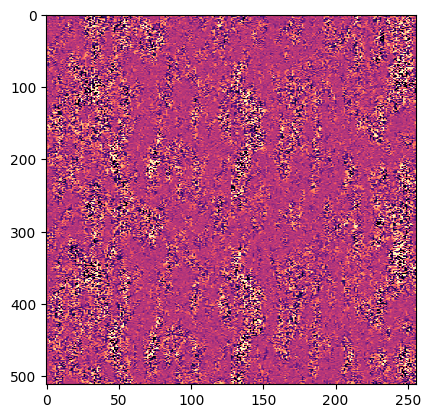

PyObject <matplotlib.image.AxesImage object at 0x13cd77c70>

In [8]:
imshow(reshape(b, n1, n2), cmap="magma", vmin=-.5, vmax=.5, aspect=.5)

# Linearized bregman

We solve the following l1-l2 optimization problem [1] for the recovery of a noisy measurment with a tall linear measurment operator.:

$$
\begin{align}
\min_x & \ \ \lambda || W x||_1 + \frac{1}{2} ||W x ||_2^2 \\
          & \text{s.t. } Ax = b
\end{align}
$$

In [9]:
# setup bregamn
opt = bregman_options(maxIter=200, verbose=2, quantile=.5)

SlimOptim.BregmanParams(2, 1.0e-8, 200, false, true, 0.5)

In [10]:
sol = bregman(A, W, zeros(Float32, n*n), b, opt);

Running linearized bregman...
Progress tolerance: 1.00e-08
Maximum number of iterations: 200
Anti-chatter correction: 1
 Iteration     Step Length Bregman residual ||A*x - b||_2^2     λ
         1     1.25000e-01     1.49188e+02     4.75737e+03     7.96331e-04 
         2     1.25000e-01     4.56443e+02     2.67917e+03     7.96331e-04 
         3     1.25000e-01     7.96774e+02     1.50704e+03     7.96331e-04 
         4     1.25000e-01     1.11383e+03     8.47712e+02     7.96331e-04 
         5     1.25000e-01     1.38640e+03     4.76839e+02     7.96331e-04 
         6     1.25000e-01     1.61038e+03     2.68222e+02     7.96331e-04 
         7     1.25000e-01     1.78937e+03     1.50875e+02     7.96331e-04 
         8     1.25000e-01     1.92980e+03     8.48672e+01     7.96331e-04 
         9     1.25000e-01     2.03860e+03     4.77378e+01     7.96331e-04 
        10     1.25000e-01     2.12216e+03     2.68525e+01     7.96331e-04 
        11     1.25000e-01     2.19264e+03     1.51046

# Plot result and convergence

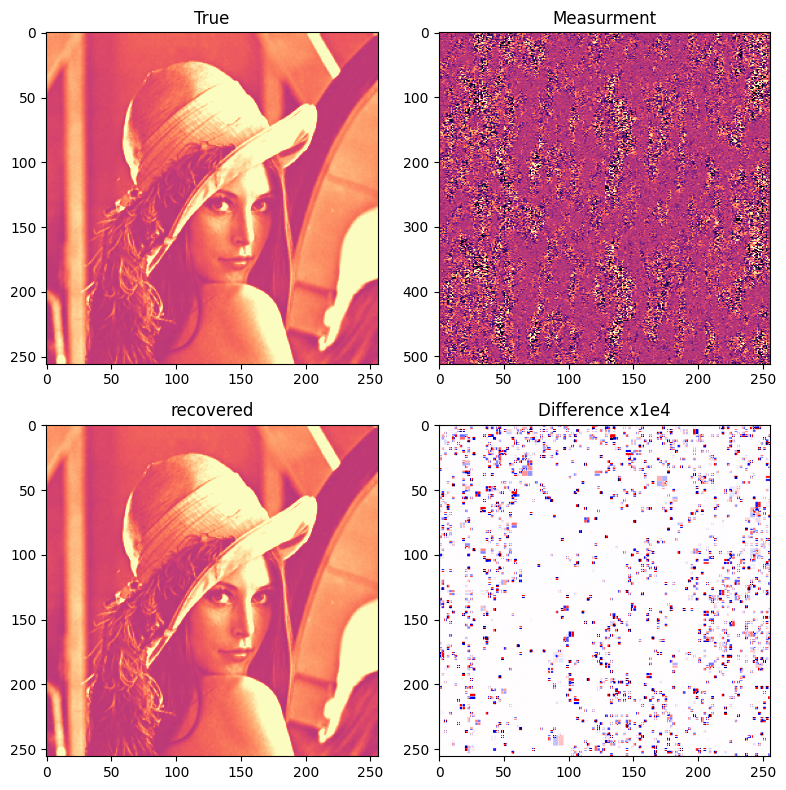

In [11]:
figure(figsize=(8,8));
subplot(221)
imshow(img, cmap="magma", vmin=-.5, vmax=.5)
title("True")
subplot(222)
imshow(reshape(b, n1, n2), cmap="magma", vmin=-.5, vmax=.5, aspect=.5)
title("Measurment")
subplot(223)
imshow(reshape(sol.x, n, n), cmap="magma", vmin=-.5, vmax=.5)
title("recovered")
subplot(224)
imshow(img - reshape(sol.x, n, n), cmap="seismic", vmin=-.5e-4, vmax=.5e-4)
title("Difference x1e4")
tight_layout()

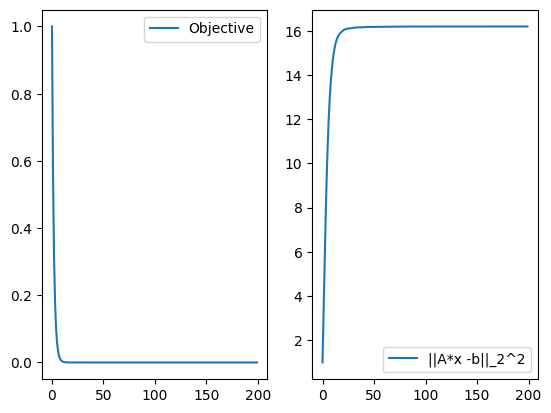

PyObject <matplotlib.legend.Legend object at 0x13d05bca0>

In [12]:
figure()
subplot(121)
plot(sol.ϕ_trace/sol.ϕ_trace[1], label="Objective")
legend()
subplot(122)
plot(sol.r_trace/sol.r_trace[1], label="||A*x -b||_2^2")
legend()